# Multisensor rail detection in automatic train operations
## Exploratory data analysis

Attila Kovacs
25.9.2023

### Load packages

In [1]:
#from config import settings
import os
from glob import glob
import random
import shutil
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from datetime import datetime

import re

import warnings
from easyimages import EasyImage, EasyImageList, bbox
from easyimages.easyimages import CTX

warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

from utils import print_image, parse_input, print_map, calculate_brightness

### Check and load data set metadata

The total numner of annotation IDs in the dataset is 236467.
Extracting this number is important in order to check against the dataframe that is being used for analysis.

In [2]:
number_labels_uid = 0
for d in os.listdir("./orig_data/DB/"):
    file_name = glob(f"./orig_data/DB/{d}/*.json")[0]
    with open(file_name) as f:
        raw = f.read()
        number_labels_uid += len(re.findall("uid", raw))
number_labels_uid

28122

In [3]:
df = parse_input()

./orig_data/DB/14_signals_station_14.1\14_signals_station_14.1_labels.json
./orig_data/DB/14_signals_station_14.2\14_signals_station_14.2_labels.json
./orig_data/DB/14_signals_station_14.3\14_signals_station_14.3_labels.json
./orig_data/DB/21_station_wedel_21.1\21_station_wedel_21.1_labels.json
./orig_data/DB/21_station_wedel_21.2\21_station_wedel_21.2_labels.json
./orig_data/DB/21_station_wedel_21.3\21_station_wedel_21.3_labels.json


In [4]:
df.head()

,longitude,latitude,tag,type,object_uid,name,label_uid,sensor,height,width,path,dataset,timestamp,label_type,closed,val,occlusion,railSide
0,9.89146,53.603349,14_signals_station_14.1,signal,0097f5ee-3819-461d-bfb2-0b5fe1cc61c3,ir_left__poly2d__signal,9c2679ee-0015-45f9-838b-3c579fd822e1,ir_left,480,640,14_signals_station_14.1/ir_left/091_1631449460...,14_signals_station_14.1,1631449460.199676000,poly2d,NaN,NaN,NaN,NaN
1,9.89146,53.603349,14_signals_station_14.1,signal,0097f5ee-3819-461d-bfb2-0b5fe1cc61c3,rgb_left__poly2d__signal,e2965781-c2d4-49a0-bbfd-966c968599cb,rgb_left,1600,2464,14_signals_station_14.1/rgb_left/091_163144946...,14_signals_station_14.1,1631449460.199676000,poly2d,NaN,NaN,NaN,NaN
2,9.89146,53.603349,14_signals_station_14.1,signal,0097f5ee-3819-461d-bfb2-0b5fe1cc61c3,rgb_center__poly2d__signal,5c53086b-ad21-497e-bb9d-9bf072a03a72,rgb_center,1600,2464,14_signals_station_14.1/rgb_center/091_1631449...,14_signals_station_14.1,1631449460.199676000,poly2d,NaN,NaN,NaN,NaN
3,9.89146,53.603349,14_signals_station_14.1,signal,0097f5ee-3819-461d-bfb2-0b5fe1cc61c3,rgb_highres_left__poly2d__signal,1b07f3de-b52f-4aab-8fbf-49e28ef85d1c,rgb_highres_left,2504,4112,14_signals_station_14.1/rgb_highres_left/091_1...,14_signals_station_14.1,1631449460.199676000,poly2d,NaN,NaN,NaN,NaN
4,9.89146,53.603349,14_signals_station_14.1,signal,0097f5ee-3819-461d-bfb2-0b5fe1cc61c3,rgb_highres_center__poly2d__signal,7a36116b-af9d-45de-9e70-dace1a12a099,rgb_highres_center,2504,4112,14_signals_station_14.1/rgb_highres_center/091...,14_signals_station_14.1,1631449460.199676000,poly2d,NaN,NaN,NaN,NaN


The images have been generated in the timefram XXX to XXX

In [5]:
# earliest record
datetime.utcfromtimestamp(float(df.timestamp.min())).strftime("%Y-%m-%d %H:%M:%S")

'2021-09-12 12:24:20'

In [6]:
# latest record
datetime.utcfromtimestamp(float(df.timestamp.max())).strftime("%Y-%m-%d %H:%M:%S")

'2021-09-15 10:53:09'

The number of annotations matches the number of unique IDs in the input file. In total, there are XXXX annotations.

In [7]:
# number of labels
assert number_labels_uid == len(df)
len(df)

28122

The number of images in the dataset is XXX

In [8]:
# number of images
len(df.path.unique())

2250

In [9]:
# lables per sensor
df["sensor"].value_counts()

sensor
rgb_highres_center    5907
rgb_center            5396
lidar                 4940
ir_center             3467
radar                 2382
rgb_left              1213
rgb_highres_right     1206
rgb_highres_left      1140
ir_left               1123
rgb_right              807
ir_right               541
Name: count, dtype: int64

In [10]:
# labeled images per sensor
df.groupby(["sensor"])["path"].nunique().sort_values()

sensor
ir_right               30
rgb_highres_right      30
rgb_right              30
ir_center             270
ir_left               270
lidar                 270
radar                 270
rgb_center            270
rgb_highres_center    270
rgb_highres_left      270
rgb_left              270
Name: path, dtype: int64

In [11]:
# annotations per label
df["type"].value_counts()

type
person               9390
signal               4264
track                3610
catenary_pole        3039
train                2298
signal_pole          1616
buffer_stop          1520
road_vehicle         1402
group_of_bicycles     480
switch                241
wagons                130
bicycle                92
transition             40
Name: count, dtype: int64

In [12]:
# images per label
df[["type", "path"]].drop_duplicates()["type"].value_counts()

type
person               2023
train                1908
buffer_stop          1270
track                1258
signal               1046
road_vehicle          710
group_of_bicycles     480
catenary_pole         330
signal_pole           285
wagons                110
switch                101
bicycle                92
transition             10
Name: count, dtype: int64

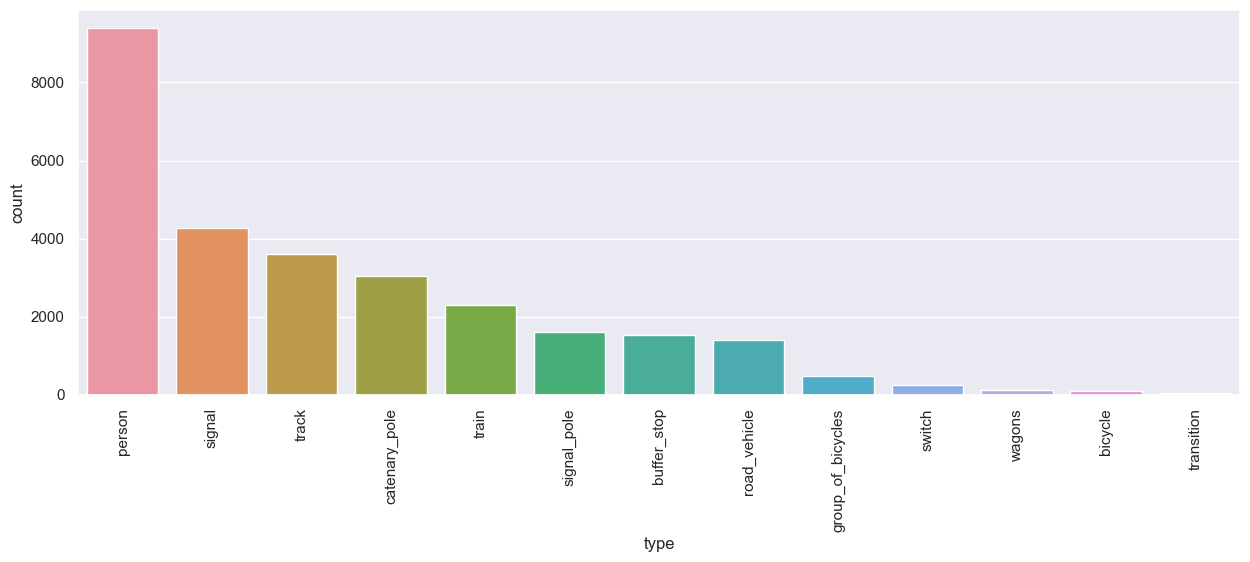

In [13]:
# classes
sns.set(rc={"figure.figsize": (15, 5)})
p = sns.countplot(x=df["type"], order=df["type"].value_counts().index)
p = p.set_xticklabels(p.get_xticklabels(), rotation=90)
# _ = p.set_title("Number of annotations per class")
plt.show()

In [14]:
# filter only on relevant data
df = df[(df["type"] == "track") & (df["label_type"] == "poly2d")]
df["poly2d"] = df.val.apply(lambda x: np.array(np.reshape(x, (-1, 2)), dtype=np.int32))

In [15]:
# number of labels
len(df)

2830

In [16]:
# number of images
len(df.path.unique())

988

In [17]:
# lables per sensor
df["sensor"].value_counts()

sensor
rgb_center            740
rgb_highres_center    740
ir_center             696
rgb_right             120
rgb_highres_right     120
ir_right              110
rgb_highres_left      110
rgb_left              102
ir_left                92
Name: count, dtype: int64

In [18]:
df_aspect = df[["path", "width", "height", "sensor"]].drop_duplicates()
df_aspect["aspect_ratio"] = df_aspect.apply(lambda x: x.width / x.height, axis=1)
df_aspect.head()

,path,width,height,sensor,aspect_ratio
20,14_signals_station_14.1/ir_center/091_16314494...,640,480,ir_center,1.333333
22,14_signals_station_14.1/rgb_center/091_1631449...,2464,1600,rgb_center,1.540000
24,14_signals_station_14.1/rgb_highres_center/091...,4112,2504,rgb_highres_center,1.642173
50,14_signals_station_14.1/ir_right/091_163144946...,640,480,ir_right,1.333333
134,14_signals_station_14.1/rgb_right/091_16314494...,2464,1600,rgb_right,1.540000


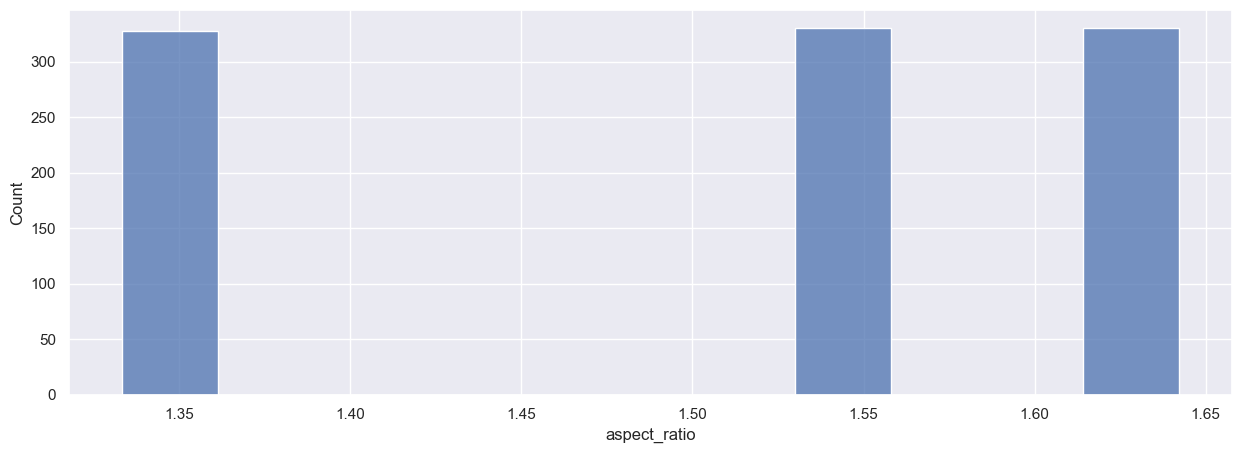

In [19]:
_ = sns.histplot(df_aspect.aspect_ratio)

<Axes: xlabel='aspect_ratio', ylabel='sensor'>

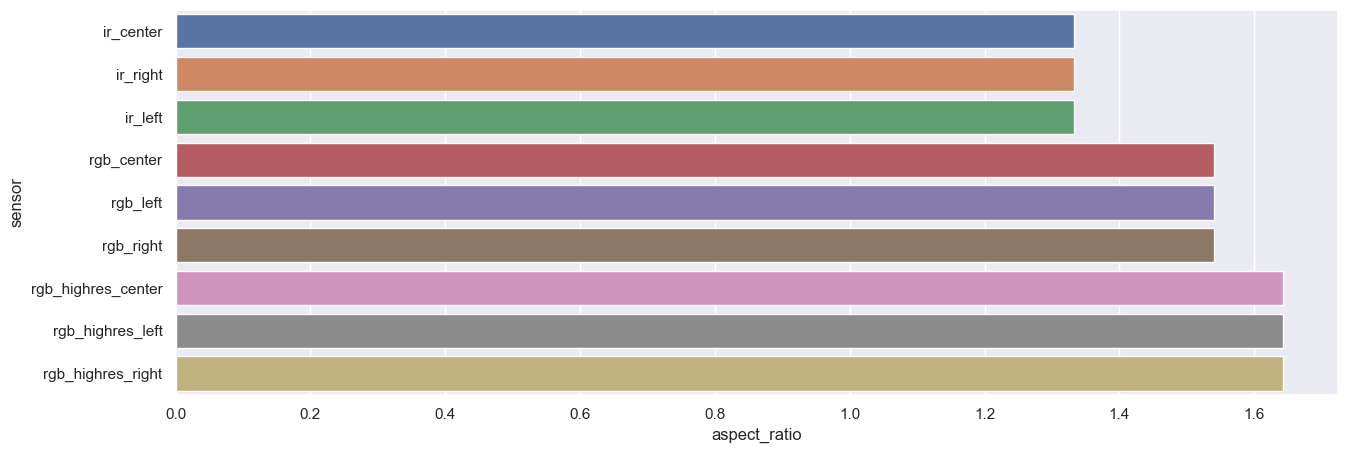

In [20]:
sns.barplot(df_aspect.sort_values("aspect_ratio"), x="aspect_ratio", y="sensor")

[Text(0.5, 1.0, 'Histogram of classes per image')]

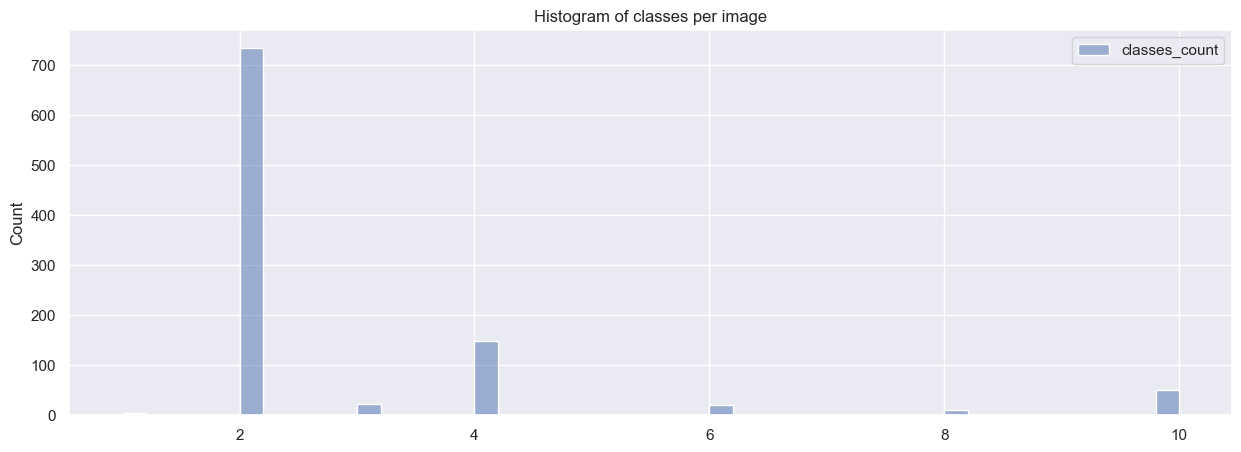

In [21]:
df_classes_count = df.groupby(["path"], as_index=False).agg(
    classes_count=("label_uid", lambda x: x.nunique())
)
sns.histplot(df_classes_count).set(title="Histogram of classes per image")

In [23]:
print_map(df)

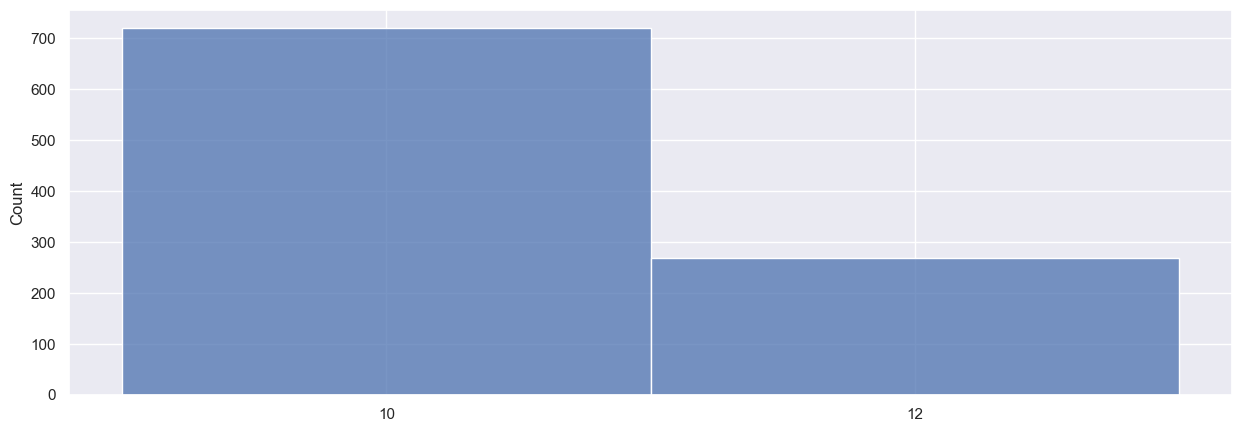

In [24]:
df_temp = (
    df[["path", "timestamp"]]
    .drop_duplicates()
    .apply(
        lambda x: datetime.utcfromtimestamp(float(x.timestamp)).strftime("%H"), axis=1
    )
    .sort_values()
)
_ = sns.histplot(df_temp)

14_signals_station_14.2/rgb_highres_center/020_1631450164.100000011.png


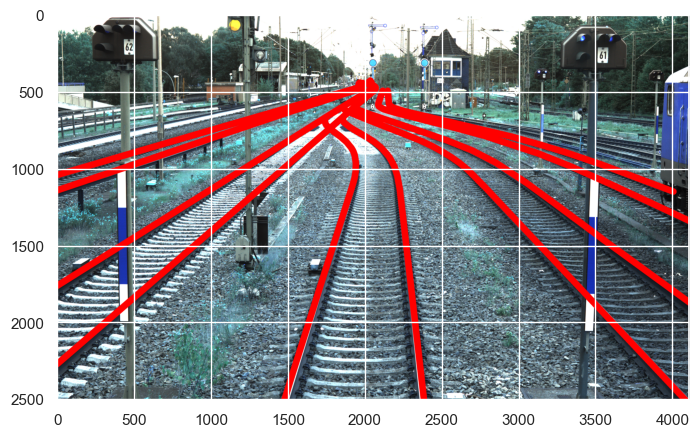

In [25]:
path = df[df.path.str.contains("high")].path.unique()[39]
print_image(df, path, True)

14_signals_station_14.1/ir_left/095_1631449460.600464540.png


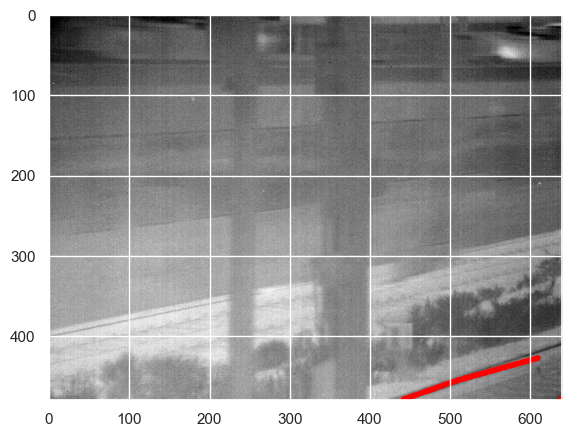

14_signals_station_14.1/ir_left/095_1631449460.600464540.png


In [26]:
path = df.path.unique()[35]
print_image(df, path, True)
print(path)

14_signals_station_14.1/rgb_center/092_1631449460.300000056.png


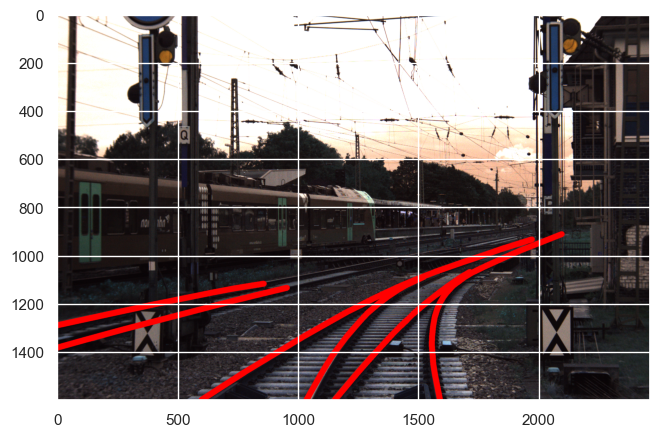

14_signals_station_14.1/rgb_center/092_1631449460.300000056.png


In [27]:
path = df.path.unique()[10]
print_image(df, path, True)
print(path)

14_signals_station_14.3/ir_center/019_1631450782.000464380.png


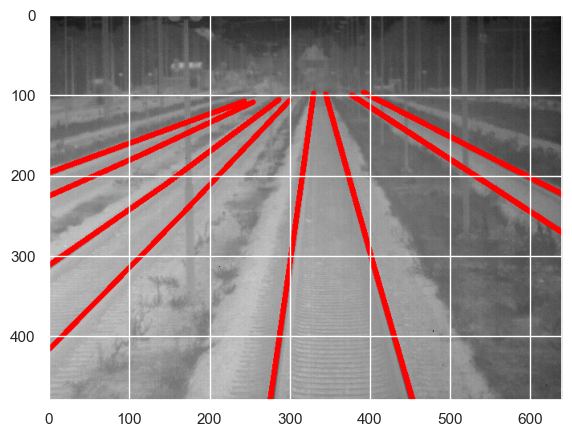

14_signals_station_14.3/ir_center/019_1631450782.000464380.png


In [28]:
path = df[df["sensor"] == "ir_center"].path.unique()[22]
print_image(df, path, True)
print(path)

In [29]:
def brightness(im_file):
    im = Image.open(im_file).convert("L")
    stat = ImageStat.Stat(im)
    return stat.rms[0]

In [ ]:
df_temp = df[["path", "sensor"]].drop_duplicates()
df_temp

In [ ]:
%%time
df_temp["brightness"] = df_temp.apply(lambda x: brightness(f"./orig_data/DB/{x.path}"), axis=1)

In [ ]:
datetime.now()

In [ ]:
df.to_json("list_of_dataset.json")

In [ ]:
_ = sns.boxplot(
    df_temp[["sensor", "brightness"]].sort_values("brightness"),
    x="sensor",
    y="brightness",
)

In [ ]:
df["poly2d"].iloc[0]

In [ ]:
sns.set(rc={"figure.figsize": (15, 15)})

df["x_max_polyline"] = df["poly2d"].apply(lambda x: abs(x[0][0] - x[-1][0]))
df["y_max_polyline"] = df["poly2d"].apply(lambda x: abs(x[0][1] - x[-1][1]))
sns.scatterplot(
    x=df["x_max_polyline"],
    y=df["y_max_polyline"],
    hue=df["sensor"].apply(lambda x: x.split("_")[-1]),
)

In [ ]:
df_temp = df[["x_max_polyline", "y_max_polyline", "path", "label_uid"]].sort_values(
    ["x_max_polyline", "y_max_polyline"], ascending=[True, False]
)
df_temp.head()

In [ ]:
path = df_temp.iloc[0]["path"]
uid = df_temp.iloc[0]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

In [ ]:
path = df_temp.iloc[1]["path"]
uid = df_temp.iloc[1]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

In [ ]:
df_temp = df[["x_max_polyline", "y_max_polyline", "path", "label_uid"]].sort_values(
    ["x_max_polyline", "y_max_polyline"], ascending=[False, True]
)
df_temp.head()

In [ ]:
path = df_temp.iloc[0]["path"]
uid = df_temp.iloc[0]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

In [ ]:
path = df_temp.iloc[105]["path"]
uid = df_temp.iloc[105]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

In [ ]:
df_temp = df[["x_max_polyline", "y_max_polyline", "path", "label_uid"]].sort_values(
    ["x_max_polyline", "y_max_polyline"], ascending=[True, True]
)
df_temp.head()

In [ ]:
path = df_temp.iloc[0]["path"]
uid = df_temp.iloc[0]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

In [ ]:
path = df_temp.iloc[10]["path"]
uid = df_temp.iloc[10]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

In [ ]:
df_temp = df[["x_max_polyline", "y_max_polyline", "path", "label_uid"]].sort_values(
    ["x_max_polyline", "y_max_polyline"], ascending=[False, False]
)
df_temp.head()

In [ ]:
path = df_temp.iloc[0]["path"]
uid = df_temp.iloc[0]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

In [ ]:
path = df_temp.iloc[20]["path"]
uid = df_temp.iloc[20]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

In [ ]:
df_temp = df
df_temp["occlusion"] = pd.Categorical(
    df_temp["occlusion"], ["0-25 %", "25-50 %", "50-75 %", "75-99 %", "100 %"]
)

In [ ]:
sns.histplot(df_temp["occlusion"])

In [ ]:
df_temp = df[df["occlusion"] == "100 %"][["path", "label_uid", "sensor"]]
len(df_temp)

In [ ]:
# images with at least 1 100% occlusion track
len(df_temp["path"].drop_duplicates())

In [ ]:
sns.histplot(df_temp, x="sensor")

In [ ]:
path = df_temp.iloc[54]["path"]
uid = df_temp.iloc[54]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

In [ ]:
path = df_temp.iloc[-10]["path"]
uid = df_temp.iloc[-10]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

In [ ]:
path = df_temp[df_temp["sensor"] == "rgb_center"].iloc[10]["path"]
uid = df_temp[df_temp["sensor"] == "rgb_center"].iloc[10]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

In [ ]:
li = EasyImageList.from_folder("./orig_data/DB/3_fire_site_3.3/rgb_highres_center/")
li.html(size=200)

In [ ]:
li = EasyImageList.from_folder("./orig_data/DB/3_fire_site_3.4/rgb_highres_center/")
li.html(size=200)

In [ ]:
li = EasyImageList.from_folder(
    "./orig_data/DB/4_station_pedestrian_bridge_4.1/rgb_highres_center/"
)
li.html(size=200)

In [ ]:
image = cv2.imread(f"./orig_data/{path}")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

rho = 0.3  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 20  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(image) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(
    edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap
)

for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)
plt.imshow(lines_edges)
plt.show()

In [ ]:
image = cv2.imread(
    f"./orig_data/15_construction_vehicle_15.1/rgb_highres_center/069_1631531288.000000005.png"
)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel_size = 15
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

rho = 0.3  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 50  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(image) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(
    edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap
)

for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 20)

lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)
plt.imshow(lines_edges)
plt.show()